In [1]:
from cycler import cycler
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import sklearn.preprocessing as skprep
import itertools

import math
import json
import io
import glob
import re
import ast

In [2]:
# load dictionary of country ids to country names, file created by country_id_dictionary.ipynb
# translate r_id and p_id to country names
i2c_json = open('id_to_country.json').read()
string_io = io.StringIO(i2c_json)
i2c = json.load(string_io)

# translate hs_codes (trade good ids) to trade good names, file created by country_id_dictionary.ipynb
hs_codes_json = open('hs_to_name.json').read()
string_io = io.StringIO(hs_codes_json)
hs_codes = json.load(string_io)

In [3]:
# parameters
YEAR = 2009 # default year if not specified when calling functions
TTD = 'C_2' # C_2 - exports, C_1 - imports. TTD stands for trade type and direction. Type is always commodity

# # Graph building functions # #

In [4]:
# build edgelist for trade in particular direction (export or import)
def build_edgelist(ttd=TTD):
    edge_list = []
    r_id_list = []
    reporters = glob.glob(f'./oc_trade/{ttd}/*.txt')
    r_id_regex = re.compile(f'./oc_trade/{ttd}\\\\([0-9]*).txt')
    for r_name in reporters:
        r_id = re.match(r_id_regex, r_name).group(1)
        r = pd.read_csv(r_name)
        if r.columns.size > 1:
            r_id_list.append(r_id)
        else:
            continue
        years = r[r.columns[0]].tolist() # first column are years
        for col in r.columns[1:]:
            # remove second column if don't want total exports of particular year and products to all countries
            # each column is a partner region
            trade_values_dict = {}
            i = 0
            for row in r[col]:
                # row is dict of particular year and trade good in string format
                if type(row) == float:
                    # no data (is nan)
                    continue
                row_dict = ast.literal_eval(row)
                exports_across_trade_goods = sum(row_dict.values())
                row_dict['total'] = exports_across_trade_goods
                year = str(years[i])
                trade_values_dict[year] = row_dict
                i += 1

                edge = (r_id, col, year, row_dict)
                edge_list.append(edge)
    return edge_list, r_id_list

In [5]:
# combined import export edgelist 
#     (fills in unreported edges, e.g. China doesn't report anything some years, 
#     we can reconstruct their trade by reports of other countries)
def build_graph():
    exp_wt, exp_reporter_ids = build_edgelist('C_2')
    imp_wt, imp_reporter_ids = build_edgelist('C_1')
    graph_wt = nx.MultiDiGraph(exp_wt)
    reporting_discrepancies = []
    for imp_edge in imp_wt:
        p_id, r_id, year, trade_values_dict = imp_edge # r and p ids are inversed to find exp relation rather than imp

        if not graph_wt.has_edge(r_id, p_id, year):
            graph_wt.add_edge(r_id, p_id, year)
            graph_wt[r_id][p_id][year].update(trade_values_dict)
        else:
            r_trade_values = graph_wt[r_id][p_id][year]
            unequal_reports, reported_by_exporter, reported_by_importer = 0, 0, 0 # statistics

            for k, v in r_trade_values.items():
                # trade value defined as max of exporter reported and importer reported values
                if k in trade_values_dict:
                    max_val = max(trade_values_dict[k], v)
                    if trade_values_dict[k] != v: unequal_reports += 1 # statistics
                else:
                    # trade goods only reported by exporter
                    max_val = v
                    reported_by_exporter += 1 # statistics
                r_trade_values[k] = max_val
            for k in trade_values_dict.keys():
                # add trade goods only reported by importer
                if k not in r_trade_values:
                    v = trade_values_dict[k]
                    r_trade_values[k] = v
                    reported_by_importer += 1 # statistics

            discrepancies = {'exp': reported_by_exporter, 'imp': reported_by_importer, 'ineq': unequal_reports} # statistics
            reporting_discrepancies.append((r_id, p_id, discrepancies)) # statistics
    return graph_wt, exp_reporter_ids, imp_reporter_ids, reporting_discrepancies

In [6]:
def calc_total_imp_exp(graph):
# for graph, create a global source/sink node for trade (warning: this effectively doubles the total trade value in the graph)
    total_exports_per_exporter = []
    for node in graph.nodes():
        global_exports = {}
        for neighbor in graph[node].values():
            for year, year_val in neighbor.items():
                for k, v in year_val.items():
                    if not year in global_exports:
                        global_exports[year] = {}
                    if not k in global_exports[year]:
                        global_exports[year][k] = v
                    else:
                        global_exports[year][k] += v
        total_exports_per_exporter.append((node, global_exports))
    global_export_edge_list = []
    for r_id, global_exports in total_exports_per_exporter:
        for year, year_val in global_exports.items():
            global_export_edge_list.append((r_id, '0', year, year_val))
    
    total_imports_per_importer = {}
    for node in graph.nodes():
        for neighbor_id in graph[node].keys():
            val = graph[node][neighbor_id]
            if not neighbor_id in total_imports_per_importer:
                total_imports_per_importer[neighbor_id] = {}
            for year, year_val in val.items():
                if not year in total_imports_per_importer[neighbor_id]:
                    total_imports_per_importer[neighbor_id][year] = {}
                for prod_id, prod_val in year_val.items():
                    if not prod_id in total_imports_per_importer[neighbor_id][year]:
                        total_imports_per_importer[neighbor_id][year][prod_id] = prod_val
                    else:
                        total_imports_per_importer[neighbor_id][year][prod_id] += prod_val
    global_import_edge_list = []
    for p_id, val in total_imports_per_importer.items():
        for year, year_val in val.items():
            global_import_edge_list.append(('0', p_id, year, year_val))
    
    graph.add_edges_from(global_export_edge_list)
    graph.add_edges_from(global_import_edge_list)
    
def calc_total_trade_value(graph):
    # total trade value over all trade goods between two nodes
    for node in graph.nodes():
        for neighbor_dict in graph[node].values():
            total_trade = sum(neighbor_dict.values())
            neighbor_dict['0'] = total_trade

In [7]:
def get_exports_above_threshold(graph, r_id, threshold_vals, trade_good):
    th_exports_by_neighbor = {}
    for neighbor_id, neighbor_val in graph[r_id].items():
        th_exports = {}
        for year, year_val in neighbor_val.items():
            if trade_good == None:
                # find any dependence
                for tg_id, val in year_val.items():
                    if tg_id in threshold_vals[year] and val >= threshold_vals[year][tg_id]: # DEBUG, sometimes tg_id doesn't exist in thresh vals
                        if not year in th_exports:
                            th_exports[year] = {}
                        th_exports[year][tg_id] = val
            elif trade_good in year_val.keys():
                # find dependence for specific trade good or for total
                val = year_val[trade_good]
                if trade_good in threshold_vals[year] and val >= threshold_vals[year][trade_good]:
                    if not year in th_exports:
                        th_exports[year] = {}
                    th_exports[year] = year_val[trade_good]
            else:
                pass
        if th_exports:
            th_exports_by_neighbor[neighbor_id] = th_exports
    return th_exports_by_neighbor

def build_threshold_graph(graph, threshold, trade_good='total'):
    # trade good: number from 01 to 99, 'total' means total
    th_edge_list = []
    for r_id in graph.nodes():
        if r_id == '0' or graph.out_degree[r_id] == 0:
            continue
        total_exports_by_year = graph[r_id]['0']
        threshold_vals = {year: {k: v*threshold for k, v in exports_by_product.items()} for year, exports_by_product in total_exports_by_year.items()}
        th_exports_by_neighbor = get_exports_above_threshold(graph, r_id, threshold_vals, trade_good=trade_good)
        for p_id, th_exports in th_exports_by_neighbor.items():
            th_edge_list.append((r_id, p_id, th_exports))
    return nx.MultiDiGraph(th_edge_list)

# # Build graph # #

In [8]:
graph_oc, exp_r, imp_r, rep_discrep = build_graph()
graph_oc.remove_node('0')
graph_oc_no_world = graph_oc.copy()

# add global source/sink
calc_total_imp_exp(graph_oc)

# build threshold graph
th_graph_oc = build_threshold_graph(graph_oc, 0.01, trade_good = 'total') # number from 01 to 99, 0 means total
th_graph_oc_no_world = th_graph_oc.copy()
th_graph_oc_no_world.remove_node('0')

# # Number of export goods dependence visualisations # #

In [9]:
# list highly dependent export goods: number of goods above threshold is counted, 
# those which are dependent above threshold for at least min_years are printed, along with the specific years of dependence
# consider exports from country r_id to the world
def find_highly_dependent_trade_goods(g, r_id, threshold=0.5):
    total_exports_by_year = g[str(r_id)]['0']
    threshold_vals = {year: {k: v*threshold for k, v in exports_by_product.items()} for year, exports_by_product in total_exports_by_year.items()}
    th_exports_by_neighbor = get_exports_above_threshold(g, str(r_id), threshold_vals, trade_good=None)
    
    return th_exports_by_neighbor

def list_dependent_trade_goods(g, r_id, threshold, min_years=3):
    th_exports_by_neighbor = find_highly_dependent_trade_goods(g, r_id, threshold)
    for neighbor, th_exports in th_exports_by_neighbor.items():
        if neighbor =='0':
            continue
        print(f'Dependence on {i2c[str(neighbor)]}')
        dependent_trade_goods_list = {}
        for year, total_exports in th_exports.items():
            for trade_good_id, val in total_exports.items():
                if trade_good_id not in dependent_trade_goods_list:
                    dependent_trade_goods_list[trade_good_id] = []
                dependent_trade_goods_list[trade_good_id].append(year)
        print('# of goods:', len(dependent_trade_goods_list))
        for k, v in dependent_trade_goods_list.items():
            if len(v) >= min_years:
                message = f'{hs_codes[str(k)]}: {str(v)}'
                print(message)
        print('\n')

list_dependent_trade_goods(graph_oc, 36, threshold=0.4, min_years=5)

Dependence on Canada
# of goods: 1


Dependence on China
# of goods: 21
05 - Animal originated products; not elsewhere specified or included: ['2004', '2005', '2009', '2010', '2011', '2012', '2013', '2014', '2015']
51 - Wool, fine or coarse animal hair; horsehair yarn and woven fabric: ['2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
47 - Pulp of wood or other fibrous cellulosic material; waste and scrap of paper or paperboard: ['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
26 - Ores, slag and ash: ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
41 - Raw hides and skins (other than furskins) and leather: ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
52 - Cotton: ['2010', '2011', '2012', '2013', '2014', '2015', '2019']
25 - Salt;

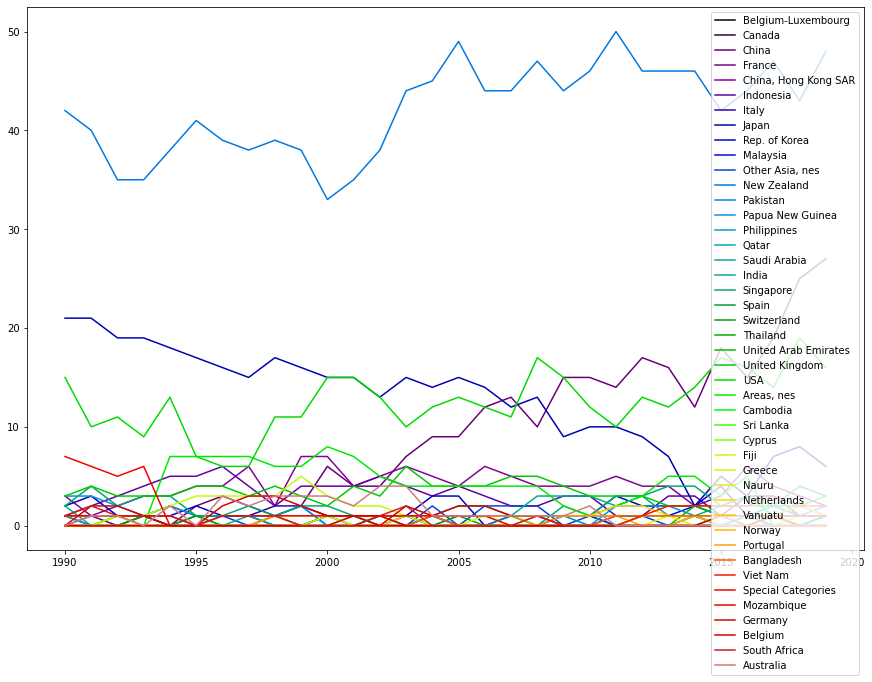

In [10]:
# graph number of export goods above certain threshold of dependence, from country r_id to all countries
def graph_dependent_trade_goods_by_year(g, r_id, threshold):
    dependence_by_neighbor = []
    neighbor_index = []
    years = [str(x) for x in range(1990,2020)]
    th_exports_by_neighbor = find_highly_dependent_trade_goods(g, str(r_id), threshold)
    ax1 = plt.figure(figsize=(15,10)).add_subplot(111)
    number_of_plots = len(th_exports_by_neighbor)
    colormap = plt.cm.nipy_spectral
    cy = cycler('color', [colormap(i) for i in np.linspace(0, 1, number_of_plots)])
    ax1.set_prop_cycle(cy)

    for neighbor, th_exports in th_exports_by_neighbor.items():
        if neighbor =='0':
            continue
        neighbor_index.append(i2c[neighbor])
        dep_goods_by_year = np.stack([[int(year), len(th_exports[year])] if year in th_exports else [int(year), 0] for year in years],axis=1)
        dependence_by_neighbor.append(dep_goods_by_year[1,:])
        ax1.plot(dep_goods_by_year[0], dep_goods_by_year[1], label=f'{i2c[str(neighbor)]}')
    
    ax1.legend()
    plt.show()
    pd.DataFrame(np.transpose(dependence_by_neighbor), columns=neighbor_index).to_csv(f'num_trade_goods_from_{r_id}_gt{threshold}_dependence_by_export_partner.csv')

graph_dependent_trade_goods_by_year(graph_oc, 36, threshold=0.2)

# # Trade good dependence lasagna (layered) graph helper functions # #

In [11]:
def calc_dependence(G, trade_good_id, i, j):
    # calculate exporter i's dependence on importer j for a particular trade good
    if not j in G[i]:
        # no trade from i to j
        years = range(1990,2020) # hard coded
        return {str(year):0 for year in years}
    exports_to_pid_by_year = {k:v[trade_good_id] if trade_good_id in v else 0 for (k,v) in G[i][j].items()}
    exports_to_world_by_year = {k:v[trade_good_id] if trade_good_id in v else 0 for (k,v) in G[i]['0'].items()}
    dependence = {}
    for k,v in exports_to_pid_by_year.items():
        denom = exports_to_world_by_year[k]
        if denom == 0:
            dependence[k] = 0
            continue
        dependence[k] = v/denom
    return dependence

def calc_dependencies_by_trade_good(g, r_id, p_id, normalize=False):
    # calculate depencences for each trade good, put in dictionary
    trade_good_ids = [f'{x:02d}' for x in range(1, 100)]
    area_plot_dict = {}
    for trade_good_id in trade_good_ids:
        dep_matrix = calc_dependence(g, trade_good_id, str(r_id), str(p_id))
        if dep_matrix:
            area_plot_dict[trade_good_id] = dep_matrix
    # convert dict to array
    area_plot_array = []
    for t_id, dep_by_year in area_plot_dict.items():
        area_plot_array.append([v for v in dep_by_year.values()])
    if normalize:
        area_plot_array_normalized = skprep.normalize(area_plot_array, axis=0, norm='l1')
        return area_plot_array_normalized
    else:
        return area_plot_array

def area_plot(area_plot_array_normalized, r_id, p_id, print_thresh=1):
    # plot lasagna graphe
    trade_good_ids = [f'{x:02d}' for x in range(1, 100)]
    years = [str(x) for x in range(1990,2020)]
    # calculate array of actual data points
    area_plot_data = np.cumsum(area_plot_array_normalized, axis=0)
    
    # print significant trade good ids
    # the print_thresh variable sets the dependence threshold to print a trade good id 
    # (good for identifying important trade goods)
    for i in range(99):
        pb = False
        ap_array = area_plot_array_normalized[i]
        for v in ap_array:
            if v > print_thresh: 
                pb = True
        if pb:
            print(i+1)
    
    # plot stacked area graph  
    ax1 = plt.figure(figsize=(30,30)).add_subplot(111)
    ax1.grid(True)
    ax1.set_yticks([x for x in range(16)])
    ax1.set_yticklabels([])
    
#     for i in range(len(trade_good_ids)):
    for i in range(len(trade_good_ids)-1,-1,-1):
        if i == 0:
            ax1.fill_between(years, 0, area_plot_data[i,:], alpha=.7)
        else:
            ax1.fill_between(years, area_plot_data[i,:], area_plot_data[i-1,:], alpha=.7)
    handles, labels = ax1.get_legend_handles_labels()
    plt.legend(trade_good_ids[::-1], loc='upper right', ncol=1, fontsize=10, bbox_to_anchor=(1.05, 0.96))
    fig = plt.gcf()
    plt.savefig(f'{i2c[str(r_id)]} export dependence on {i2c[str(p_id)]}')

    pd.DataFrame(np.transpose(area_plot_data), columns=[f'{x:02d}' for x in range(1, 100)], index=[str(x) for x in range(1990,2020)]).to_csv(f'cumulative_trade_good_dependence_{r_id}_to_{p_id}.csv')

# # Lasagna graphs # #

1
15
26
44
51
81
99


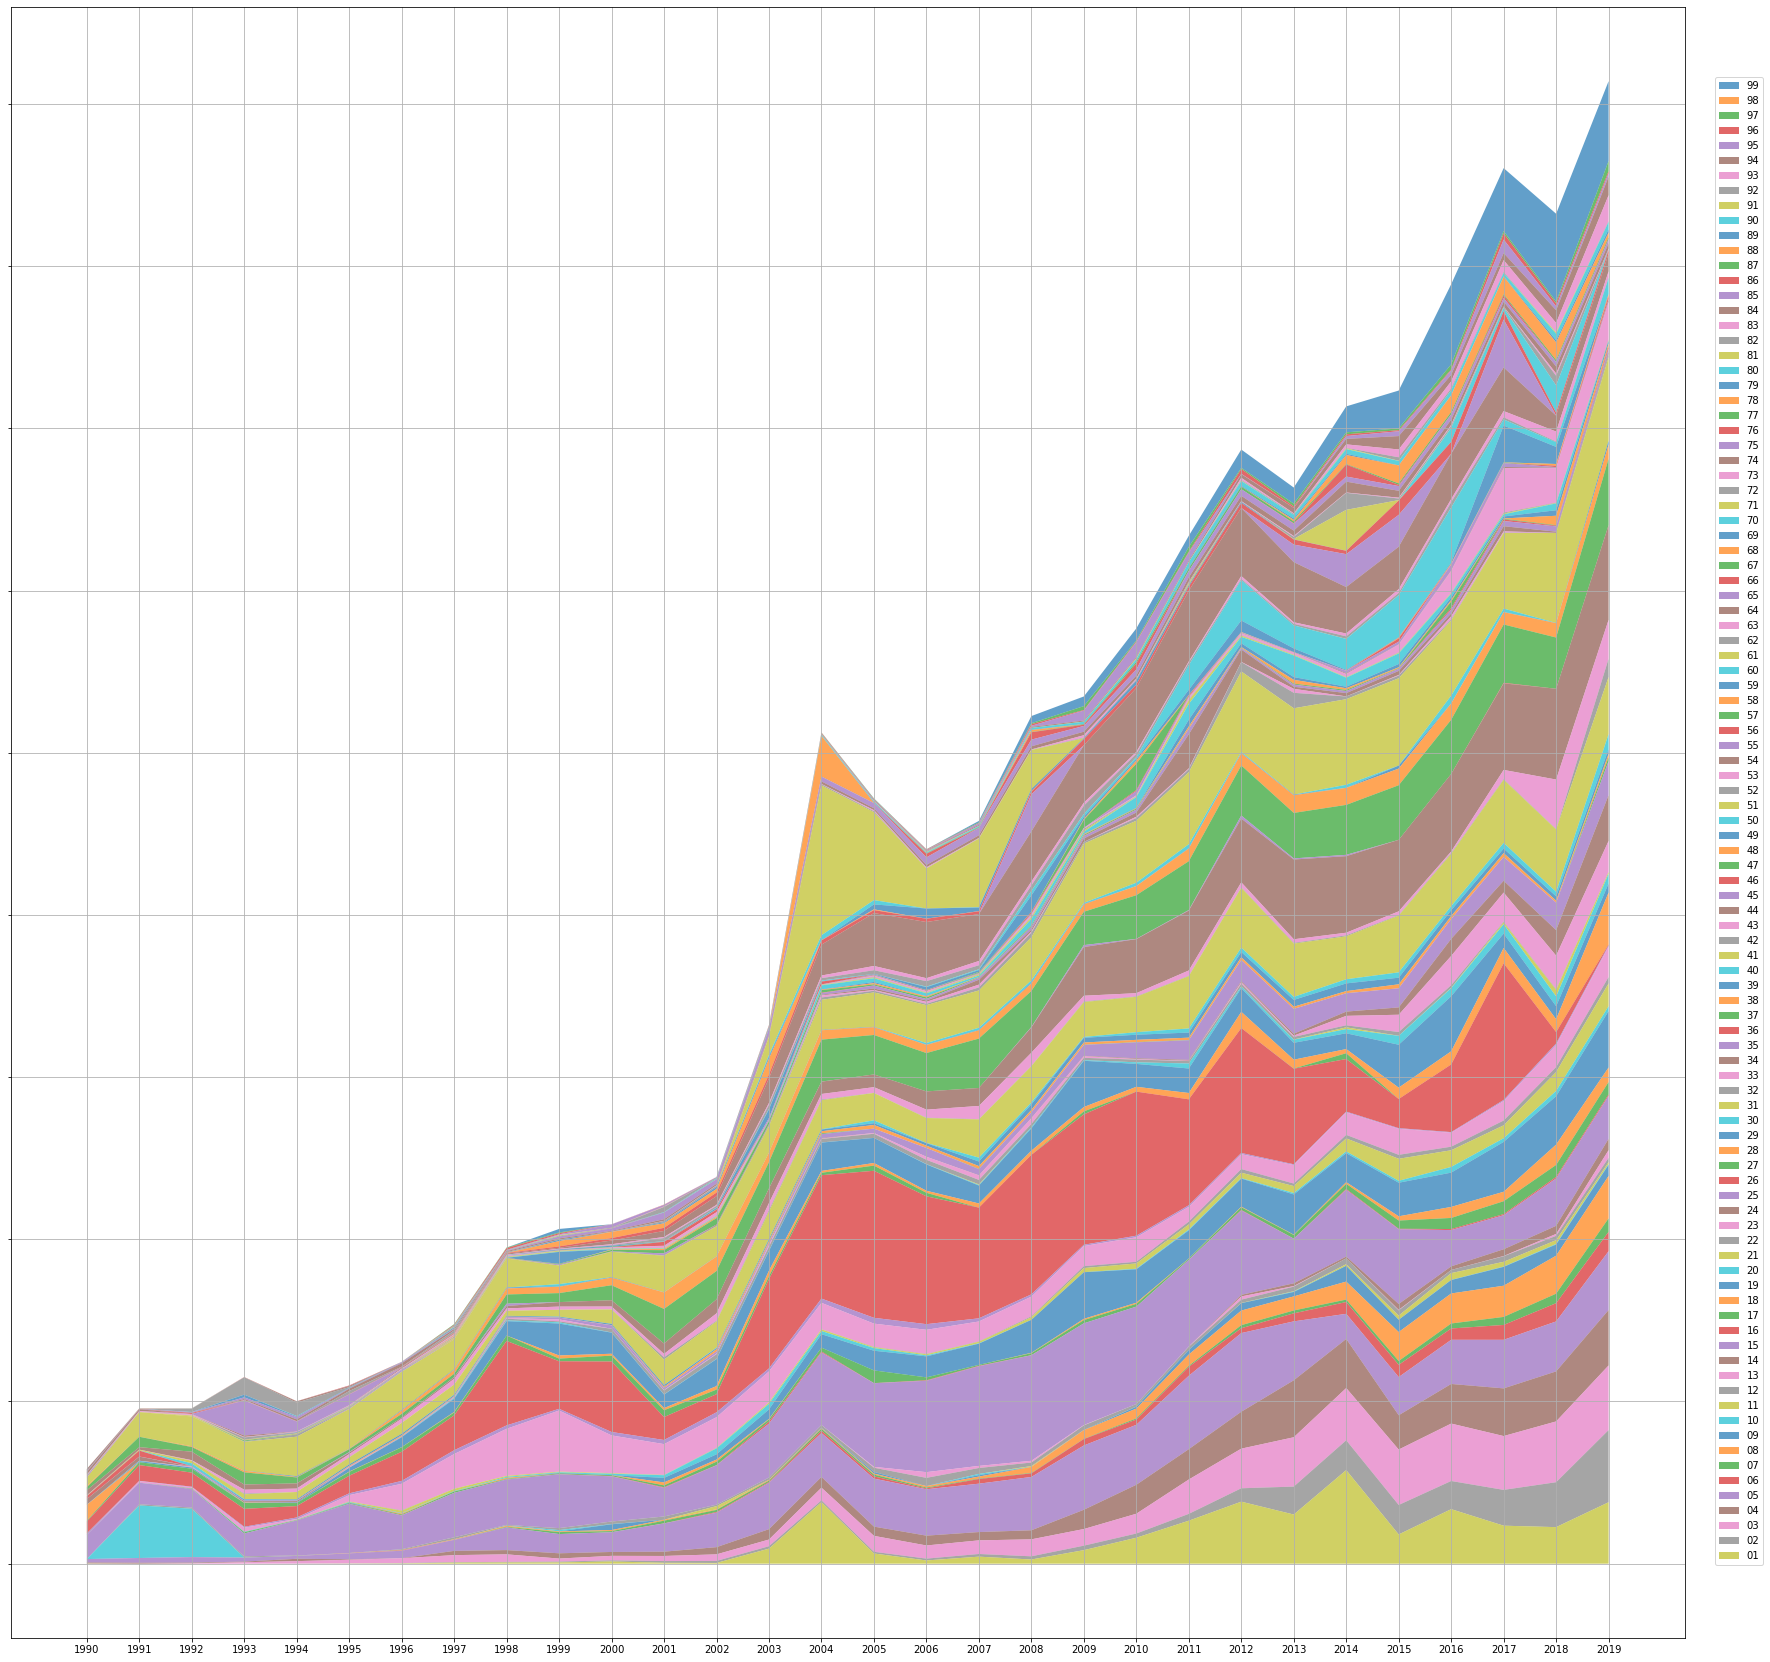

In [12]:
# plot r_id's export dependence on p_id for each trade good for each year
# dependences are calculated for individual trade goods and layered on each other
# grid lines denote 1 unit (1 unit of dependence means 100% dependence for a trade good)
# grid lines are just to help visualize individual trade good dependences
def plot_dependence_by_year_by_trade_good(g, r_id, p_id, normalize):
    area_plot_array_normalized = calc_dependencies_by_trade_good(g, r_id, p_id, normalize)
    area_plot(area_plot_array_normalized, r_id, p_id, print_thresh=0.5)

plot_dependence_by_year_by_trade_good(graph_oc, 554, 156, False)

2
4
44
51


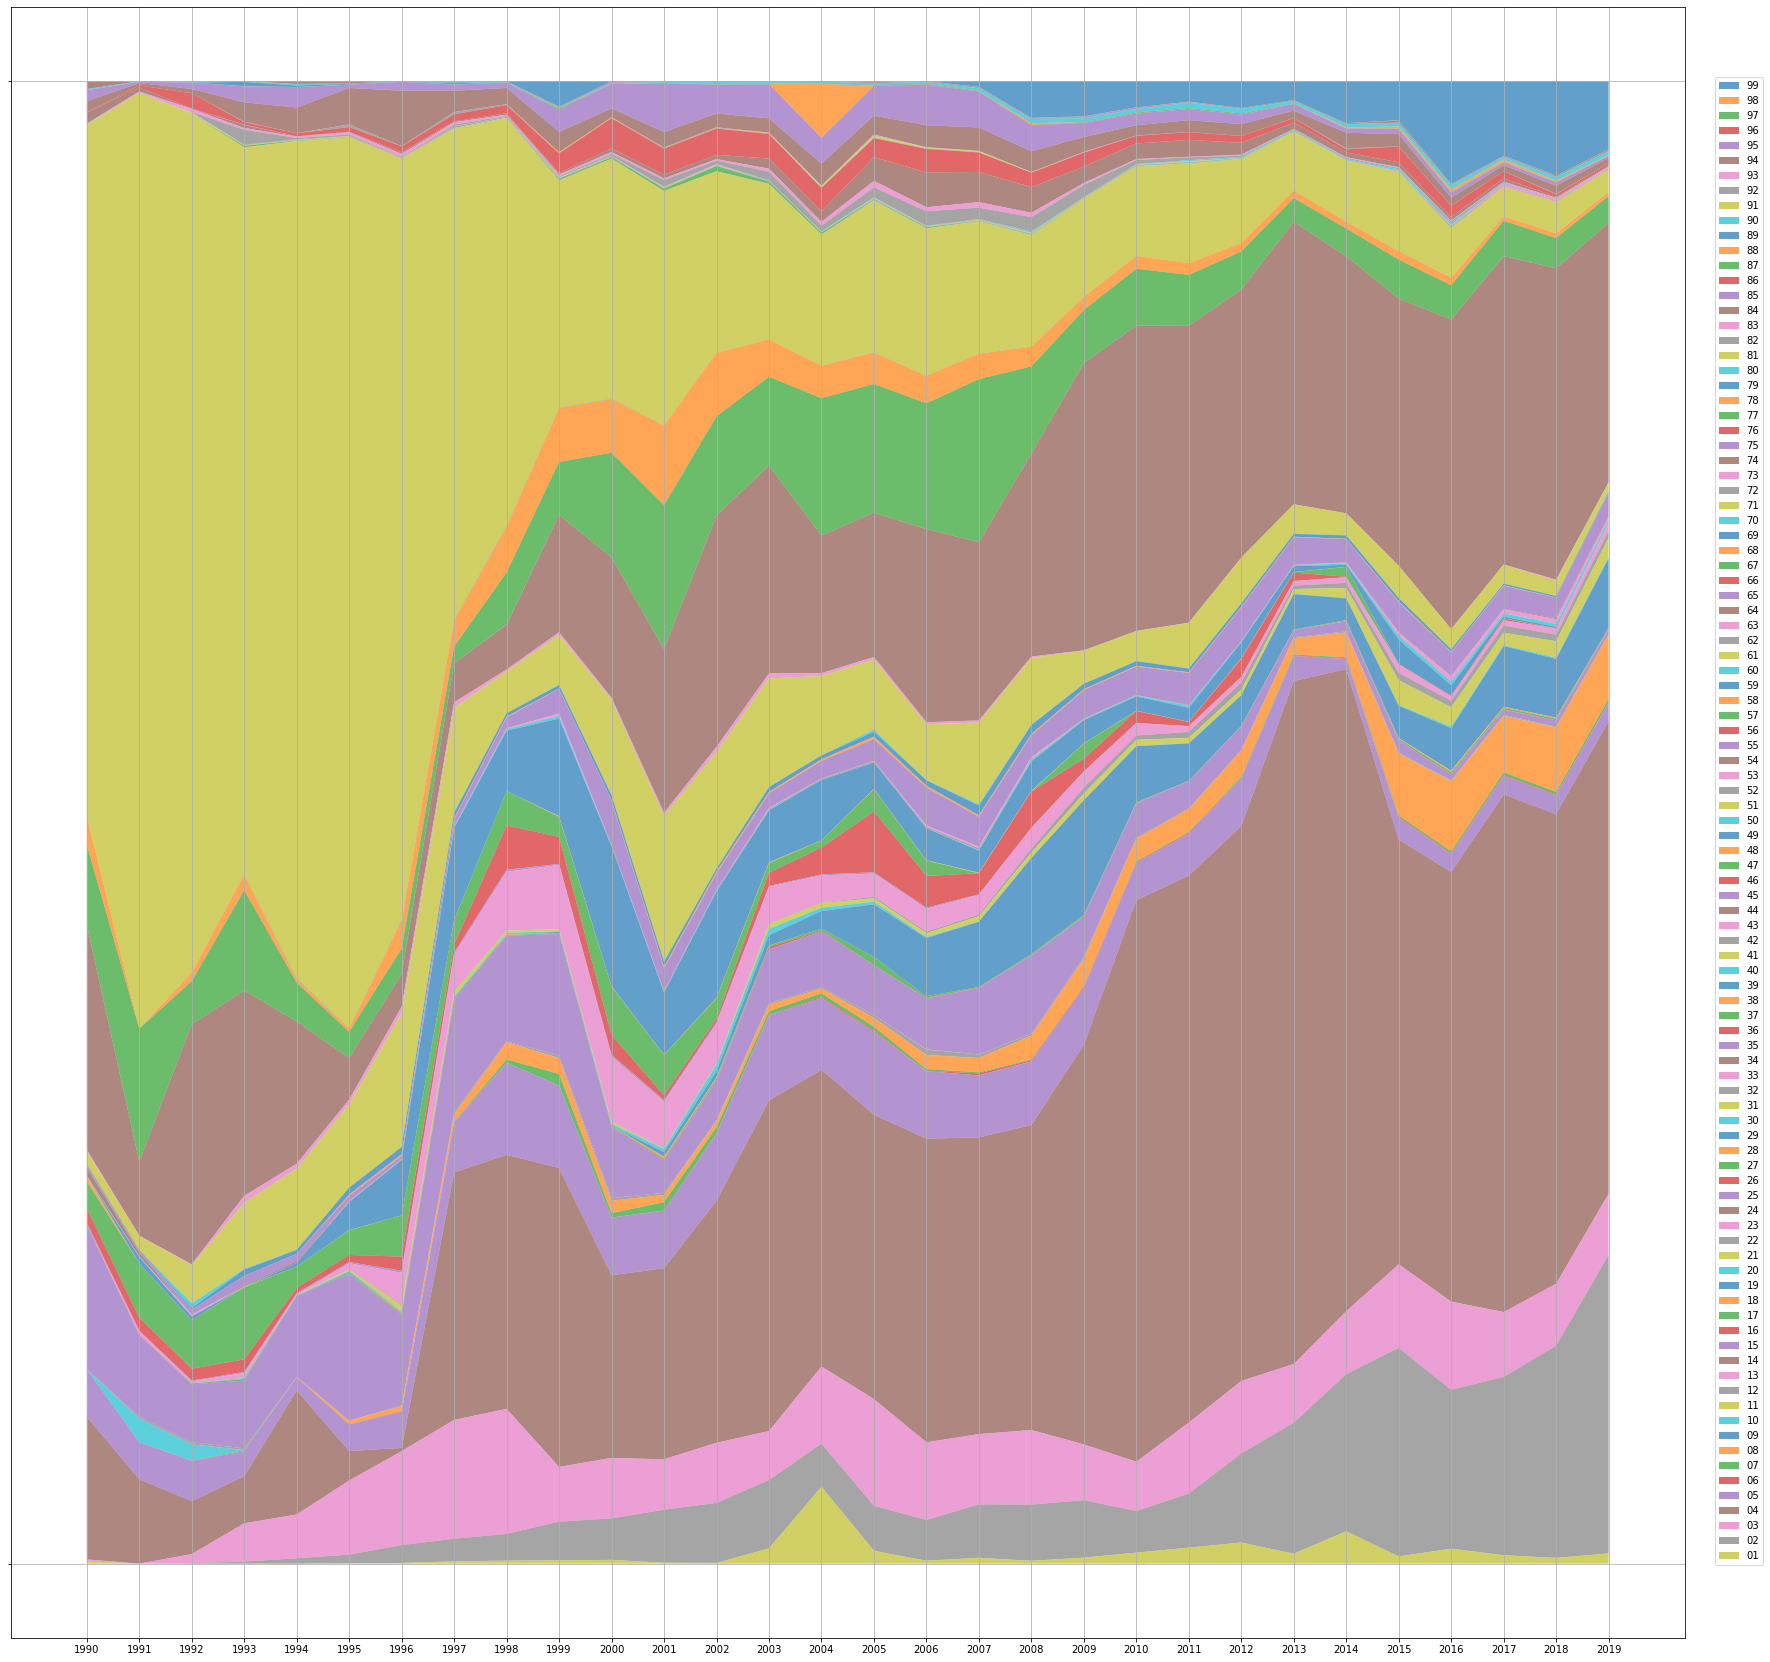

In [13]:
def calc_trade_good_proportions(g, r_id, p_id, normalize=True):
    # proportions of dollar values of exports
    # calculate depencences for each trade good, put in dictionary
    trade_good_ids = [f'{x:02d}' for x in range(1, 100)]
    years = [str(x) for x in range(1990,2020)]
    area_plot_dict = g[str(r_id)][str(p_id)].copy()
    # convert dict to array
    area_plot_array = []
    for year in years:
        if not year in area_plot_dict:
            area_plot_dict[year] = {}
        exports = area_plot_dict[year]
        area_plot_array.append([exports[trade_good_id] if trade_good_id in exports else 0 for trade_good_id in trade_good_ids])
    area_plot_array = np.transpose(area_plot_array)
    if normalize:
        area_plot_array_normalized = skprep.normalize(area_plot_array, axis=0, norm='l1')
        return area_plot_array_normalized
    else:
        return area_plot_array

# plot composition of r_id's export to p_id by year - ratio of dollar values of export goods
# if normalize set to false, plot actual trade values
def plot_trade_good_proportions_by_year(g, r_id, p_id, normalize):
    area_plot_array_normalized = calc_trade_good_proportions(g, r_id, p_id, normalize)
    area_plot(area_plot_array_normalized, r_id, p_id, print_thresh=0.2)

plot_trade_good_proportions_by_year(graph_oc, 554, 156, True)

# # Other export dependence visualisation tools # #

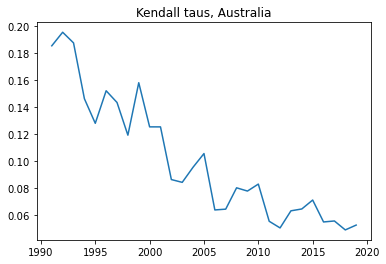

In [14]:
# plot kendall-tau distances between the export value rankings for trade goods for each two consecutive years from 1990 to 2019

def calc_kt(prev_exs, cur_exs):
    # get lists of trade good ids as inputs, sorted by trade dollar value
    # insert non-mutual elements at end of the lists, since KT can only be computed on lists with identical elements
    add_to_prev = set(cur_exs) - set(prev_exs)
    add_to_cur = set(prev_exs) - set(cur_exs)
    prev_exs.extend(list(add_to_prev))
    cur_exs.extend(list(add_to_cur))
    
    prev_ids = range(len(prev_exs))
    cur_ids = []
    for tid in prev_exs:
        cur_ids.append(cur_exs.index(tid))
    
    index_pairs = itertools.combinations(range(len(cur_ids)), 2)

    distance = 0

    for x, y in index_pairs:
        a = prev_ids[x] - prev_ids[y]
        b = cur_ids[x] - cur_ids[y]

        # if discordant (different signs)
        if (a * b < 0):
            distance += 1
    
    n = len(prev_exs)
    denominator = n*(n-1)/2
    
    return distance / denominator

def calc_kendall_tau_distances(r_id, g):
    ex_to_cn = g[r_id]['156']
    ex_to_world = g[r_id]['0']
    kendall_taus = []
    prev_year_exs = None
    for year, exs in ex_to_cn.items():
        if not prev_year_exs:
            prev_year_exs = exs
            continue
        kt = calc_kt([x[0] for x in sorted(prev_year_exs.items(), key=lambda x: x[1], reverse=True)], [x[0] for x in sorted(exs.items(), key=lambda x: x[1], reverse=True)])
#         kendall_taus.append((year, kt))
        kendall_taus.append(kt)
        prev_year_exs = exs
    return kendall_taus

taus = calc_kendall_tau_distances('36', graph_oc) # changing the country id here to 554 allows looking at NZ kt distances
plt.title('Kendall taus, Australia')
plt.plot(range(1991, 2020), taus) # the range is not a typo, 1991 is the second year of the 1990-1991 KT distance

In [15]:
# trade dependences of Australia and New Zealand, this is calculated and used by other functions
def calc_trade_dependence_matrix(G, trade_good_id='total', nodes=None):
    dependence_matrix = {}
    for i in ['36', '554']:
        if i == '0': continue
        if not i in dependence_matrix.keys():
            dependence_matrix[i] = {}
        for j in G.nbunch_iter(nodes):
            if j == '0': continue
            if i is j:
                dependence_matrix[i][j] = {} # no trade means no dependence
            dependence_matrix[i][j] = calc_dependence(G, trade_good_id, i, j)
    return dependence_matrix

dependence_matrix = calc_trade_dependence_matrix(graph_oc, trade_good_id=None)

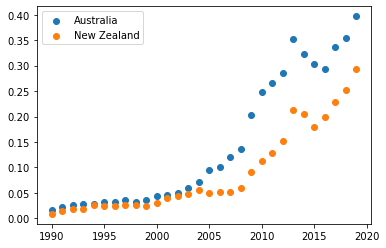

In [16]:
# australia and new zealand export dependence on China
def oc_dependence_on_china_by_year_by_trade_good(g, trade_good_id='total'):
    dependence_matrix = calc_trade_dependence_matrix(g, trade_good_id)
    # New Zealand and Australian dependence on Chinese trade over time
    oz_dependence_cn = [(k,v) for k,v in dependence_matrix['36']['156'].items()]
    plt.scatter(y=[x[1] for x in oz_dependence_cn], x=[int(x[0]) for x in oz_dependence_cn], label='Australia')
    nz_dependence_cn = [(k,v) for k,v in dependence_matrix['554']['156'].items()]
    plt.scatter(y=[x[1] for x in nz_dependence_cn], x=[int(x[0]) for x in nz_dependence_cn], label='New Zealand')
    plt.legend()
    plt.show()

oc_dependence_on_china_by_year_by_trade_good(graph_oc, 'total')

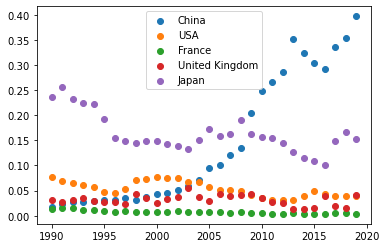

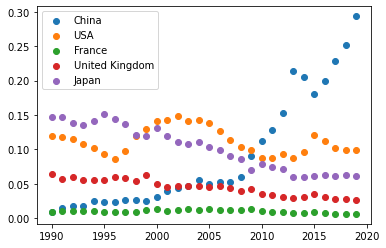

In [17]:
# export dependence on various countries, year on year
# first graph shows australia's dependence, second graph shows new zealand's dependence
def export_dependence_on_countries_by_year(g, r_id, p_ids=[156,842,251,826,392], trade_good_id='total'):
    dependence_matrix = calc_trade_dependence_matrix(g, trade_good_id)
    for p_id in p_ids:
        exports_to_pid = [(k,v) for k,v in dependence_matrix[str(r_id)][str(p_id)].items()]
        plt.scatter(y=[x[1] for x in exports_to_pid], x=[int(x[0]) for x in exports_to_pid], label=f'{i2c[str(p_id)]}')
#         plt.scatter(y=[math.log(x[1]) for x in exports_to_pid], x=[int(x[0]) for x in exports_to_pid], label=f'{i2c[str(p_id)]}')
    plt.legend()
    plt.show()

export_dependence_on_countries_by_year(graph_oc, 36, trade_good_id='total')
export_dependence_on_countries_by_year(graph_oc, 554, trade_good_id='total')

[('China', 0.3969457836892473), ('Japan', 0.15205931885512267), ('Rep. of Korea', 0.06730571583176036), ('United Kingdom', 0.04073777621524636), ('USA', 0.039197130941545), ('India', 0.03739233774246367), ('Other Asia, nes', 0.034063254469512035), ('Singapore', 0.03226469480776052), ('New Zealand', 0.02727391454197886), ('Malaysia', 0.023831261227610808), ('Other', 0.14892881167775252)]


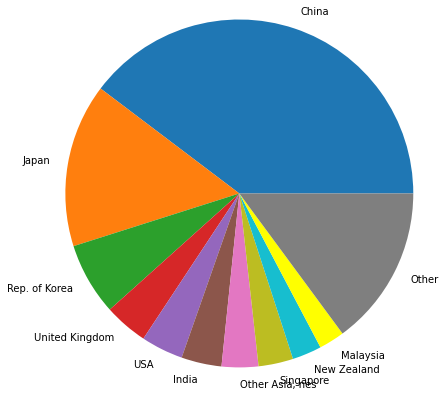

In [18]:
# pie chart for export dependencies of a particular country for a particular year and a particular export good
def ao(top_list):
    other = 1 - sum([x[1] for x in top_list])
    u = [(i2c[i], val) for i, val in top_list]
    u.append(('Other', other))
    return u

def top_10_export_dependencies_pie_by_year(g, r_id, year, trade_good_id='total'):
    # plot constants
    r = 1
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#bcbd22', '#17becf', '#ffff00',
              '#7f7f7f']
    
    dependence_matrix = calc_trade_dependence_matrix(g, trade_good_id)

    # look at dependences by year for australia
    total_dependence_by_year = {}
    for pid, dependence_by_year in dependence_matrix[str(r_id)].items(): # 36 is oz, 554 is nz
        for year, value in dependence_by_year.items():
            if not year in total_dependence_by_year.keys():
                total_dependence_by_year[year] = {}
            total_dependence_by_year[year][pid] = value

    # top 10 export targets for oz goods in a given year
    top_list = sorted(total_dependence_by_year[str(year)].items(), key=lambda x:x[1], reverse=True)[:10]



    top_list_ao = ao(top_list)
    print(top_list_ao)

    # graph trade share per year
    plt.pie([x[1] for x in top_list_ao], labels=[x[0] for x in top_list_ao], normalize=True, colors=colors, radius=2)
    plt.show()

year_top_10_export_dependencies = 2019
top_10_export_dependencies_pie_by_year(graph_oc, 36, year_top_10_export_dependencies, trade_good_id='total')